In [71]:
from dotenv import load_dotenv

load_dotenv()

True

# 데이터 등록

In [61]:
import os
import secrets

from tqdm.auto import tqdm, trange
import pandas as pd

from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings


def generate_hash() -> str:
    """24자리 무작위 hex 값을 생성하고 6자리씩 나누어 '-'로 연결합니다."""
    random_hex = secrets.token_hex(12)
    return "-".join(random_hex[i : i + 6] for i in range(0, 24, 6))


pinecone_api_key = os.environ["PINECONE_API_KEY"]
openai_api_key = os.environ["OPENAI_API_KEY"]
index_name = os.environ["PINECONE_INDEX_NAME"]

# SUMMARY 문자열 받아오기
df = pd.read_csv("data/PET_PLACES.csv")
texts = df[df["SUMMARY"].notna()]["SUMMARY"].tolist()

# pinecone 인덱스 받아오기
pc = Pinecone(api_key=pinecone_api_key)
index = pc.Index(name=index_name)
index.describe_index_stats()

# pinecone 인덱스에 임베딩 후 upsert
embeddings = OpenAIEmbeddings()
batch_size = 32
for i in trange(0, len(texts), batch_size):
    i_end = min(i + batch_size, len(texts))
    context_batch = texts[i: i_end]

    ids = [generate_hash() for _ in range(i, i_end)]
    dense_embeds = embeddings.embed_documents(context_batch)

    vectors = [
        {
            "id": _id,
            "values": dense,
            "metadata": {
                "text": text,
                "source": "PET_PLACES.csv",
            }
        }
        for _id, dense, text in zip(ids, dense_embeds, context_batch)
    ]

    index.upsert(vectors=vectors)

/var/folders/dn/nwjs23j94h3489_1w10d3x280000gr/T/ipykernel_60358/2819964422.py:23: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/PET_PLACES.csv")


  0%|          | 0/292 [00:00<?, ?it/s]

In [63]:
import os

from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings


pinecone_api_key = os.environ["PINECONE_API_KEY"]
openai_api_key = os.environ["OPENAI_API_KEY"]
index_name = os.environ["PINECONE_INDEX_NAME"]


# pinecone 인덱스 받아오기
pc = Pinecone(api_key=pinecone_api_key)
index = pc.Index(name=index_name)
index.describe_index_stats()

embeddings = OpenAIEmbeddings()
vectorstore = PineconeVectorStore(index=index, embedding=embeddings)

query = "who was Benito Mussolini?"
# vectorstore.similarity_search(
#     query,  # our search query
#     k=3  # return 3 most relevant docs
# )

# 웹 검색 with Tavily

In [67]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults


tool = TavilySearchResults(max_results=1)
tools = [tool]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [68]:
llm_with_tools.invoke("What is Langgraph?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4xIVjAp8eB29FyVsIscZW5lf', 'function': {'arguments': '{"query":"Langgraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 84, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_898ac29719', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-30028c76-096b-4ea7-b4c8-0870f1049790-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Langgraph'}, 'id': 'call_4xIVjAp8eB29FyVsIscZW5lf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 20, 'total_tokens': 104, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_de

In [69]:
import json
from typing import Annotated
from typing_extensions import TypedDict

from langchain_core.messages import ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]  # 메시지 누적


class BasicToolNode:
    """
    A node that runs the tools requested in the last AIMessage.
    마지막 AIMessage에서 요청된 도구를 실행하는 노드
    """

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]  # 마지막 message
        else:
            raise ValueError("No message found in input")

        outputs = []
        for tool_call in message.tool_calls:  # 메시지에서 호출된 도구를 불러옴
            # Tool 호출 실행
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])

            # Tool 호출 결과(ToolMessage) 추가
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # if the last message has "tool_calls"
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


graph_builder = StateGraph(State)

# 노드 정의
tool_node = BasicToolNode(tools=[tool])

# 노드 추가
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# 엣지 연결
graph_builder.add_edge("tools", "chatbot") # 도구가 호출될 때마다 챗봇으로 돌아가 다음 단계를 결정
graph_builder.add_edge(START, "chatbot")

# 조건부 엣지 연결
# 시작 노드에서 반환값이 tools면 tools 노드로, END면 END로 이동
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {
        "tools": "tools",
        END: END,
    },
)

graph = graph_builder.compile()

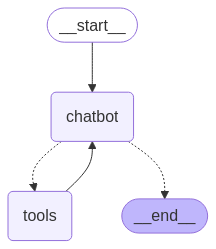

In [70]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    # graph 노드 호출 결과 받아옴
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)

# RAG + 웹검색

In [77]:
import os
import json
from typing import Annotated
from typing_extensions import TypedDict

from pinecone import Pinecone

from langchain_pinecone import PineconeVectorStore
from langchain.embeddings import OpenAIEmbeddings
from langchain_core.messages import ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


pinecone_api_key = os.environ["PINECONE_API_KEY"]
openai_api_key = os.environ["OPENAI_API_KEY"]
index_name = os.environ["PINECONE_INDEX_NAME"]

# pinecone 인덱스 받아오기
pc = Pinecone(api_key=pinecone_api_key)
index = pc.Index(name=index_name)
index.describe_index_stats()

embeddings = OpenAIEmbeddings()
vectorstore = PineconeVectorStore(index=index, embedding=embeddings)
retriever = vectorstore.as_retriever()

# 상태 타입 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 메시지 누적


# 기존의 Tool Node (Websearch tool 등)
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]  # 마지막 message
        else:
            raise ValueError("No message found in input")

        outputs = []
        for tool_call in message.tool_calls:  # 호출된 도구 처리
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


# Chatbot 노드 (LLM 호출)
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# RAG 노드: Pinecone에서 관련 문서를 검색해 메시지에 추가
def rag_node(state: State):
    messages = state.get("messages", [])
    if not messages:
        raise ValueError("No messages found for RAG")
    latest_message = messages[-1]

    # 여기서는 최신 메시지의 내용을 쿼리로 사용합니다.
    query = latest_message.content

    # Pinecone 벡터스토어에서 유사도 검색 수행 (상위 3개 문서)
    retrieved_docs = vectorstore.similarity_search(query, k=3)

    # 각 문서의 내용을 하나의 컨텍스트 문자열로 결합
    context = "\n".join([doc.page_content for doc in retrieved_docs])

    # 원래 쿼리에 추가 컨텍스트를 덧붙임
    updated_content = f"{query}\n\n[추가 컨텍스트]\n{context}"
    latest_message.content = updated_content

    return state


# 검색, 웹서치 툴
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return the summarized blog post content on pet-friendly facilities.",
)

web_search_tool = TavilySearchResults(max_results=1)
tools = [retriever_tool, web_search_tool]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

# 그래프 빌더 구성
graph_builder = StateGraph(State)

# 노드 추가
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# 엣지 연결: tool 호출 후 챗봇 노드로 돌아감
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 조건부 엣지 연결:
# 시작 노드에서 반환값이 tools면 tools 노드로, END면 END로 이동
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {
        "tools": "tools",
        END: END,
    },
)

graph = graph_builder.compile()


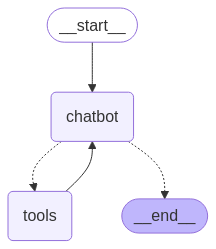

In [76]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [89]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]


from pinecone import Pinecone

from langchain_pinecone import PineconeVectorStore
from langchain.embeddings import OpenAIEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool



pinecone_api_key = os.environ["PINECONE_API_KEY"]
openai_api_key = os.environ["OPENAI_API_KEY"]
index_name = os.environ["PINECONE_INDEX_NAME"]

# pinecone 인덱스 받아오기
pc = Pinecone(api_key=pinecone_api_key)
index = pc.Index(name=index_name)
index.describe_index_stats()

embeddings = OpenAIEmbeddings()
vectorstore = PineconeVectorStore(index=index, embedding=embeddings)
retriever = vectorstore.as_retriever()

# 검색, 웹서치 툴
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return the summarized blog post content on pet-friendly facilities.",
)

web_search_tool = TavilySearchResults(max_results=1)
tools = [retriever_tool, web_search_tool]



from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field



### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    # 왜 question이 첫 메시지인지?
    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
search = ToolNode([web_search_tool])
workflow.add_node("search", search)  # web search
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")




def tools_condition(state):
    """
    Agent의 마지막 메시지를 분석하여 다음 노드로 'retrieve' 또는 'search'를 반환합니다.
    예를 들어, 메시지에 'retrieve_blog_posts' 호출이 포함되어 있으면 'retrieve'를,
    'TavilySearchResults' 호출이 포함되어 있으면 'search'를 반환하도록 합니다.
    """
    messages = state.get("messages", [])
    if not messages:
        return END
    last_message = messages[-1]
    
    # last_message에 tool_calls 속성이 있고, 그 안에서 각 도구 호출의 이름을 확인
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            if tool_call["name"] == "retrieve_blog_posts":
                return "retrieve"
            elif tool_call["name"] == "TavilySearchResults":
                return "search"
    
    return END


# Decide whether to retrieve or search
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "retrieve": "retrieve",
        "search": "search",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")
workflow.add_edge("search", "generate")

# Compile
graph = workflow.compile()

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


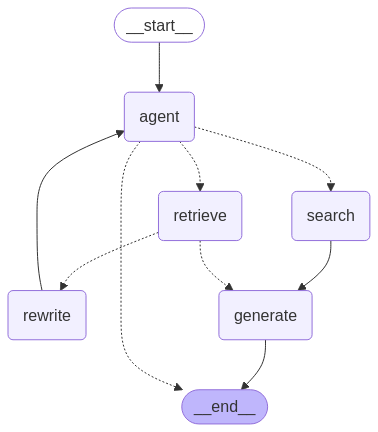

In [90]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [92]:
graph.invoke({"messages": "100코달리 와인바에 대해 설명해줘"})

---CALL AGENT---


{'messages': [HumanMessage(content='100코달리 와인바에 대해 설명해줘', additional_kwargs={}, response_metadata={}, id='d10c1db2-383a-4336-a55b-330fb724e792'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_VbwAOHJYRtgfQVaAq2g6k6l0', 'function': {'arguments': '{"query":"100코달리 와인바"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'}, id='run-247a62a3-a69b-4759-a479-c99c8cb71910-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '100코달리 와인바'}, 'id': 'call_VbwAOHJYRtgfQVaAq2g6k6l0', 'type': 'tool_call'}])]}